# Compare overlap of predictions with the Gingras lab's COVID-19 interactome

- https://covid19interactome.org/
- https://www.biorxiv.org/content/10.1101/2020.09.03.282103v1


In [1]:
# the rest of the imports require the location to be the base of the repo 
#   i.e., SARS-CoV-2-network-analysis)
# run this first if needed to get to the right directory
import os
os.chdir('../../')
# os.chdir('/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis')
os.getcwd()

'/data/jeff-law/projects/2020-03-covid-19/SARS-CoV-2-network-analysis'

In [25]:
from collections import defaultdict
import argparse
import os, sys
from tqdm import tqdm
import itertools
#import utils.file_utils as utils
# also compute the significance of sinksource vs local
#from scipy.stats import kruskal, mannwhitneyu
# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import hypergeom
print("python version: %s" % (sys.version.split('\n')[0]))
print("matplotlib version: %s" % matplotlib.__version__)
print("seaborn version: %s" % sns.__version__)
print("pandas version: %s" % pd.__version__)
print("numpy version: %s" % (np.__version__))
# make this the default for now
sns.set_style('darkgrid')
# my local imports
# fss_dir = os.path.dirname(os.path.dirname(os.path.dirname(__file__)))
# sys.path.insert(0,fss_dir)
from src.FastSinkSource.src import main as run_eval_algs
from src.FastSinkSource.src.plot import plot_utils
from src.FastSinkSource.src.algorithms import runner
from src.FastSinkSource.src.algorithms import alg_utils
from src.FastSinkSource.src.utils import config_utils
from src.FastSinkSource.src.evaluate import cross_validation as cv

%matplotlib inline  

python version: 3.7.7 (default, Mar 13 2020, 13:32:22) 
matplotlib version: 3.2.1
seaborn version: 0.10.0
pandas version: 1.0.3
numpy version: 1.18.2


In [28]:
def load_all_pred(input_settings, output_dir, alg_settings, use_alg_plot_name=True, k=100, **kwargs):
#     df_all = pd.DataFrame()
    order = []
    dataset_alg_prots = defaultdict(dict)
    # read in the predictions, and test for the statistical significance of overlap 
    for dataset in input_settings['datasets']:
        print("Loading data for %s" % (dataset['net_version']))
        base_out_dir = "%s/enrichment/%s/%s" % (output_dir, dataset['net_version'], dataset['exp_name'])
        # load the network and the positive examples for each term
        net_obj, ann_obj, eval_ann_obj = run_eval_algs.setup_dataset(
            dataset, input_settings['input_dir'], **kwargs)
        prots = net_obj.nodes
        prot_universe = set(prots)
        print("\t%d prots in universe" % (len(prot_universe)))
        # TODO using this for the SARS-CoV-2 project,
        # but this should really be a general purpose script
        # and to work on any number of terms 
        orig_pos_idx, _ = alg_utils.get_term_pos_neg(ann_obj.ann_matrix, 0)
        orig_pos = [prots[p] for p in orig_pos_idx]

#         # now load the predictions, test at the various k values, and TODO plot
#         k_to_test = enrichment.get_k_to_test(dataset, **kwargs)
#         print("\ttesting %d k value(s): %s" % (len(k_to_test), ", ".join([str(k) for k in k_to_test])))

        # now load the prediction scores
        dataset_name = config_utils.get_dataset_name(dataset)
        alg_pred_files = config_utils.get_dataset_alg_prediction_files(
            output_dir, dataset, alg_settings, use_alg_plot_name=not use_alg_plot_name, **kwargs)
        for alg, pred_file in alg_pred_files.items():
            if use_alg_plot_name:
                alg = plot_utils.ALG_NAMES.get(alg,alg)
            if not os.path.isfile(pred_file):
                print("Warning: %s not found. skipping" % (pred_file))
                continue
            print("reading: %s" % (pred_file))
            df = pd.read_csv(pred_file, sep='\t')
            # remove the original positives
            df = df[~df['prot'].isin(orig_pos)]
            df.reset_index(inplace=True, drop=True)
            topk_predictions = list(df.iloc[:k]['prot'])
            # UPDATE: Also load the node score pvals, and keep only the nodes with a pval < 0.05
            pval_file = pred_file.replace('outputs/','outputs/viz') \
                                 .replace('.txt','-1000rand-10kmeans-pvals.tsv')
            print("reading pvals from: %s" % (pval_file))
            df_pval = pd.read_csv(pval_file, sep='\t', index_col=0)
            df_pval = df_pval[df_pval['pval'] < 0.05]
            print("\t%d prots with pval < 0.05" % (len(df_pval)))
            df = df[df['prot'].isin(df_pval.index)]
            print("%d of the top %s prots have pval < 0.05" % (len(set(topk_predictions) & set(df_pval.index)), k))
            
            df.reset_index(inplace=True, drop=True)
            #df = df[['prot', 'score']]
            df.sort_values(by='score', ascending=False, inplace=True)
            if k is not None:
                topk_predictions = list(df.iloc[:k]['prot'])
                dataset_alg_prots[dataset_name][alg] = topk_predictions
            else:
                dataset_alg_prots[dataset_name][alg] = df
#             order.append(dataset_name)
            order.append(alg)
    return dataset_alg_prots, order, prots

In [4]:
config_files = [
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
    "fss_inputs/config_files/string-tissuenet-wace2/string.yaml",
#     "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml",
]
neg_factor = 5
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression']
# k_to_test = [100,200,300]
k_to_test = [332, 1000]

In [51]:
# manually change the order of the heatmap to match the clustergrid output
algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression', 'localplus']
# algs = ['localplus', 'genemaniaplus', 'sinksourceplus', 'svm', 'logistic_regression', 'genemania']
# algs = ['genemaniaplus', 'sinksourceplus', 'svm', 'logistic_regression', 'genemania']

In [59]:
k_results = []
for k in k_to_test:
    all_dataset_prots = {}
    order = []
    for config_file in config_files:
        print(config_file)
        config_map = plot_utils.load_config_file(config_file)
        kwargs = {}
        input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                config_map, '', **kwargs)
        # set additional options here
        kwargs['algs'] = algs
        kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
        kwargs['cross_validation_folds'] = 5
        kwargs['cv_seed'] = None
        kwargs['sample_neg_examples_factor'] = neg_factor
        print(kwargs)

        dataset_alg_prots, curr_order, prots = load_all_pred(input_settings, output_settings['output_dir'], alg_settings, k=k, **kwargs)
        all_dataset_prots.update(dataset_alg_prots)
        order += curr_order
        print("%d datasets" % (len(dataset_alg_prots)))
        print(order)
    #     title = set_title(**kwargs)
    #     print(title)
    #     order = pointplot(df_all, out_file=out_file, order=order)
    k_results.append(dataset_alg_prots)
order = order[:len(algs)]

fss_inputs/config_files/string-tissuenet-wace2/string.yaml
{'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'postfix': '', 'algs': ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression', 'localplus'], 'cross_validation_folds': 5, 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos pr

In [10]:
# also read in the dataset to compare with
gingras_prots_file = "datasets/protein-networks/2020-09-biorxiv-gingras-saint-virus-merged.txt"
df = pd.read_csv(gingras_prots_file, sep="\t")
df.head()

,Bait,Prey,PreyGene,Spec,SpecSum,AvgSpec,NumReplicates,ctrlCounts,AvgP,MaxP,...,FoldChange,BFDR,ctrlSubtracted,CLSC,Specificity,UniqueSpec,UniqueSpecSum,UniqueAvgSpec,PreySequenceLength,UniProtID
0,E,geneid:100101267;refseq:NP_001092885;uniprot:A...,POM121C,8|7,15,7.5,2,0|2|2|3|0|0|0|0|5|5|3|3,0.01,0.01,...,1.73,0.25,5.58,3.11,1.35,6|6,12,6.0,987,P121C_HUMAN
1,E,geneid:10010;refseq:NP_001186064;uniprot:Q92844,TANK,4|5,9,4.5,2,16|17|16|13|14|0|0|0|20|16|16|20,0.00,0.00,...,0.24,0.62,0.00,0.00,0.00,4|4,8,4.0,425,TANK_HUMAN
2,E,geneid:100134938;refseq:NP_001107875;uniprot:B...,UPK3BL1,2|3,5,2.5,2,0|0|0|0|0|0|0|0|0|0|0|0,0.98,0.99,...,25.00,0.00,2.50,5.23,9.29,2|3,5,2.5,263,UPK3L_HUMAN
3,E,geneid:10051;refseq:NP_001002800;uniprot:Q9NTJ3,SMC4,0|2,2,1.0,2,4|2|3|5|7|0|0|0|4|6|3|0,0.00,0.00,...,0.17,0.62,0.00,0.00,0.00,0|2,2,1.0,1288,SMC4_HUMAN
4,E,geneid:10059;refseq:NP_005681;uniprot:O00429,DNM1L,4|0,4,2.0,2,54|65|46|40|44|0|0|0|42|48|42|51,0.00,0.00,...,0.04,0.62,0.00,0.00,0.00,4|0,4,2.0,699,DNM1L_HUMAN


In [30]:
# keep only lines with an FDR <= 0.01
df2 = df[df['BFDR'] <= 0.01]
# print(len(set(df2['PreyGene'].values)))
# pull out the uniprot ID from the Prey column
prot_ids = df2['Prey'].values
gingras_prots = set([p.split('uniprot:')[-1] for p in prot_ids])
gingras_universe = set([p.split('uniprot:')[-1] for p in df['Prey'].values])
print("%d gingras prots, %d net prot universe, %d gingras universe, %d in common" % (
    len(gingras_prots), len(prots), len(gingras_universe), len(set(prots) & gingras_universe)))

2242 gingras prots, 18886 net prot universe, 4402 gingras universe, 4346 in common


In [55]:
def overlap_heatmap(alg_prots, order, k, compare_to_dataset, net_universe, ax=None, annot=False, out_file=None, verbose=False):
    # compute the ovlerap between each dataset
    overlaps = defaultdict(dict)
    pvals = defaultdict(dict)
    for i, (alg, prots1) in enumerate(sorted(alg_prots.items())):
        # compute the size of the overlap and the hypergeometric test 
#             jaccard_index = len(set(prots1) & set(prots2)) / float(len(set(prots1) | set(prots2)))
        overlap = len(set(prots1) & set(compare_to_dataset))
        overlaps[alg][k] = overlap
        
        # also run the hypergeometric test
        # number of draws is the # prots in the network
        num_draws = len(prots1)
        # number of successes is the # predictions that overlap with the dataset
        num_successes = overlap
        # number of success stats in the population is the # prots in the dataset
        num_success_states_in_pop = len(compare_to_dataset)
        M, n, N, curr_k = len(net_universe), num_success_states_in_pop, num_draws, num_successes
        # Use k-1 since the survival function (sf) gives 1-cdf. The cdf at k gives the probability of drawing k or fewer. The sf at k is the probability of drawing k+1 or more
        # https://blog.alexlenail.me/understanding-and-implementing-the-hypergeometric-test-in-python-a7db688a7458
        # https://github.com/scipy/scipy/issues/7837
        pval = hypergeom.sf(curr_k-1, M, n, N)
        pvals[alg][k] = "%0.2f" % pval if pval > 0.05 else "%0.2e" % pval

    df = pd.DataFrame(overlaps)[order]
#     if verbose:
    print(df.head())
    df2 = pd.DataFrame(pvals)[order]
    print(df2.head())
    # now make a heatmap of all the datasets
#     f, ax = plt.subplots(figsize=(18,28))
#     cbar = True if k == k_to_test[-1] else False
#     if annot:
#         ax = sns.heatmap(data=(df*100).astype(int), cmap="YlGnBu", cbar=cbar, annot=True, fmt='d', ax=ax)
#     else:
#         ax = sns.heatmap(data=df, cmap="YlGnBu", cbar=cbar, ax=ax)
#     ax.set_title("k = %s" % (k))
#     if out_file is not None:
#         out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
#         print(out_file)
#         os.makedirs(os.path.dirname(out_file), exist_ok=True)
#     #     plt.savefig(out_file, bbox_inches='tight')
#         # plt.savefig(out_file.replace('.pdf','.png'), bbox_inches='tight')
#         # also write the values to a file
#     #     df.to_csv(out_file.replace('.pdf','.csv'))
#     return ax

# overlap_heatmap(alg_prots, order, k, gingras_prots)

In [60]:
annot = True
datasets = k_results[0].keys()
for dataset in datasets:
#     f, axes = plt.subplots(ncols=3, sharey=True)
    for i, dataset_alg_prots in enumerate(k_results):
        k = k_to_test[i]
#         ax = axes[i]
        alg_prots = dataset_alg_prots[dataset]
#         ax = overlap_heatmap(alg_prots, order, k, ax=ax)
        ax = overlap_heatmap(alg_prots, order, k, gingras_prots, prots)

#     alg_str = '-'.join(algs) if len(algs) <= 3 else "%dalgs" % (len(algs))
#     plt.suptitle("Heatmap of Jaccard Index for %s" % (dataset), y=1.02)
#     out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
#     print(out_file)
#     os.makedirs(os.path.dirname(out_file), exist_ok=True)
#     if annot:
#         plt.savefig(out_file.replace('.pdf','-ann.svg'), bbox_inches='tight')
#     else:
#     #     plt.savefig(out_file, bbox_inches='tight')
#         plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
#     plt.show()
#     plt.close()
# #     break

      RL  GM   SS  SVM  LogReg  Local
332  115  30  144  135      70     23
           RL    GM        SS       SVM    LogReg Local
332  6.77e-28  0.96  3.77e-48  2.36e-41  1.04e-06  1.00
       RL  GM   SS  SVM  LogReg  Local
1000  336  57  371  294      91    130
            RL    GM         SS       SVM    LogReg Local
1000  5.55e-78  0.91  2.63e-101  1.48e-53  3.55e-04  0.14


In [7]:
# compute the ovlerap between each dataset
overlaps = defaultdict(dict)
for i, (d1, prots1) in enumerate(sorted(all_dataset_prots.items())):
    for j, (d2, prots2) in enumerate(sorted(all_dataset_prots.items())):
        if j == i: 
            overlaps[d1][d2] = 1
            continue
        # intersection / union
        jaccard_index = len(set(prots1) & set(prots2)) / float(len(set(prots1) | set(prots2)))
        overlaps[d1][d2] = jaccard_index
df = pd.DataFrame(overlaps)
df = df[order]
df = df.T[order].T
df.head()

,STRING400,STRING400
STRING400,1,1
STRING400,1,1


# Compare parameters of a single method


In [5]:
def plot_dataset_k_results(k_results, algs, write_out_file=True):
    datasets = k_results[0].keys()
    for dataset in datasets:
        f, axes = plt.subplots(ncols=len(k_results), sharey=True)
        for i, dataset_alg_prots in enumerate(k_results):
            k = k_to_test[i]
            ax = axes[i]
            alg_prots = dataset_alg_prots[dataset]
            overlap_heatmap(alg_prots, order, k, ax=ax)

        alg_str = '-'.join(algs) if len(algs) <= 3 else "%dalgs" % (len(algs))
        plt.suptitle("Heatmap of Jaccard Index for %s" % (dataset), y=1.02)
        if write_out_file:
            out_file = "outputs/viz/networks/overlap/%s-%s-jaccard.pdf" % (dataset, alg_str)
            print(out_file)
            os.makedirs(os.path.dirname(out_file), exist_ok=True)
            plt.savefig(out_file, bbox_inches='tight')
            plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
        plt.show()
        plt.close()

In [6]:
config_files = [
#     "fss_inputs/config_files/combined/string-tissuenet-lung.yaml",
#     "fss_inputs/config_files/string-tissuenet-wace2/string.yaml",
    "fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml",
]
neg_factor = 5
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'svm', 'logistic_regression']
algs = ['genemaniaplus']
k_to_test = [300,1000]

fss_inputs/config_files/params-testing/400-cv5-nf5-nr100-ace2.yaml
{'cross_validation_folds': 5, 'num_pred_to_write': -1, 'num_reps': 100, 'sample_neg_examples_factor': 5, 'palette': 'Set2', 'svg': True, 'postfix': '', 'algs': ['genemaniaplus'], 'cv_seed': None}
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos prots are in the largest cc
	18886 p

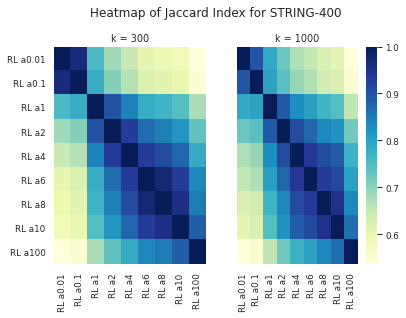

In [7]:
rename_alg_params = {
    "-tol1e-05":"", "-tol1e-04":"", "-rep100-nf5":"","-l2":"", "-maxi1000":"","-maxi100":"", "-eps0": "",
    "-a": " a", "-C":" C", "-l":" l", "_": "."}
for alg in algs:
    k_results = []
    for k in k_to_test:
        all_dataset_prots = {}
        order = []
        for config_file in config_files:
            print(config_file)
            config_map = plot_utils.load_config_file(config_file)
            kwargs = {}
            input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
                    config_map, '', **kwargs)
            # set additional options here
            kwargs['algs'] = [alg]
            kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
            kwargs['cross_validation_folds'] = 5
            kwargs['cv_seed'] = None
            kwargs['sample_neg_examples_factor'] = neg_factor
            print(kwargs)

            dataset_alg_prots, curr_order = load_all_pred(
                input_settings, output_settings['output_dir'], alg_settings, k=k, use_alg_plot_name=False, **kwargs)
            
            # change the parameters that are included in the output string
            new_dataset_alg_prots = defaultdict(dict)
            new_curr_order = []
            for d in dataset_alg_prots:
                for curr_alg in curr_order:
                    new_alg = curr_alg
                    for p1, p2 in rename_alg_params.items():
                        new_alg = new_alg.replace(p1,p2)
                    new_dataset_alg_prots[d][new_alg] = dataset_alg_prots[d][curr_alg]
                    new_curr_order.append(new_alg)
            dataset_alg_prots = new_dataset_alg_prots
            curr_order = new_curr_order
            
            all_dataset_prots.update(dataset_alg_prots)
            order += curr_order
            print("%d datasets" % (len(dataset_alg_prots)))
            print(order)
        #     title = set_title(**kwargs)
        #     print(title)
        #     order = pointplot(df_all, out_file=out_file, order=order)
        k_results.append(dataset_alg_prots)
    order = order[:len(curr_order)]
    plot_dataset_k_results(k_results, [alg], write_out_file=True)
#     break

## Now measure the spearman's correlation of both the ranks and the scores between methods

In [22]:
from scipy.stats import spearmanr

In [39]:
# manually change the order of the heatmap to match the clustergrid output
# algs = ['genemaniaplus', 'genemania', 'sinksourceplus', 'sinksource', 'svm', 'logistic_regression', 'localplus']
algs = ['localplus', 'genemaniaplus', 'sinksourceplus', 'svm', 'logistic_regression', 'genemania']

In [40]:
for config_file in config_files:
    print(config_file)
    config_map = plot_utils.load_config_file(config_file)
    kwargs = {}
    input_settings, alg_settings, output_settings, out_pref, kwargs = plot_utils.setup_variables(
            config_map, '', **kwargs)
    # set additional options here
    kwargs['algs'] = algs
    kwargs['num_reps'] = 100  # load all 100 repetitions of negative sampling and CV
    kwargs['sample_neg_examples_factor'] = neg_factor

    df_all = load_all_pred_scores(
        input_settings, output_settings['output_dir'], alg_settings, k=None, use_alg_plot_name=True, **kwargs)

fss_inputs/config_files/string-tissuenet-wace2/string.yaml
Loading data for networks/stringv11/400
	reading sparse nets from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-sparse-nets.mat
	reading node ids file from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-node-ids.txt
	reading network_names from fss_inputs/networks/stringv11/400/sparse-nets/c400-combined_score-net-names.txt
Reading annotation matrix from fss_inputs/networks/stringv11/400/sparse-anns/combined_score-2020-03-sarscov2-human-ppi-ace2-pos.npz
	18886 nodes, 977789.0 edges
1 connected_components; sizes: max: 18886, 75%: 18886, median: 18886, 25%: 18886
	100.00% nodes in the largest cc
top 20 connected_components sizes:
18886
329/329 (100.00%) pos prots are in the largest cc
	18886 prots in universe
reading: outputs//networks/stringv11/400/2020-03-sarscov2-human-ppi-ace2//localplus/pred-scores-l0.txt
reading: outputs//networks/stringv11/400/2020-03-sarscov2-human-ppi-ace2//genemaniap

In [41]:
def pred_score_spearman(df_all, verbose=False):
    df = df_all.reset_index()
    df.rename(columns={'index': 'Rank', 'score': 'Score'}, inplace=True)
    df = df.pivot(index="prot", columns="Algorithm", values="Score")
#     df.head()
    # compute the spearman correlation between each dataset
    overlaps = defaultdict(dict)
    order = df_all['Algorithm'].unique()
    print(order)
    for i, a1 in enumerate(order):
        for j, a2 in enumerate(order):
#             if i >= j:
#                 continue
            if i == j:
                overlaps[a1][a2] = 1
                continue
            curr_df = df.sort_values(a1, ascending=False)[[a1, a2]].dropna()
    #         df2.sort_values('Score', ascending=False, inplace=True)
    #         print(curr_df.head())
    #         print(df2.head())
            correlation, pvalue = spearmanr(curr_df[a1], curr_df[a2])
#             print(a1, a2, correlation, pvalue, len(curr_df))
            overlaps[a1][a2] = correlation
    df = pd.DataFrame(overlaps)
#     print(df.head())
    df = df[order]
    df = df.T[order].T
    if verbose:
        print(df.head())
    return df

['Local' 'RL' 'SS+' 'SVM' 'LogReg' 'GM']


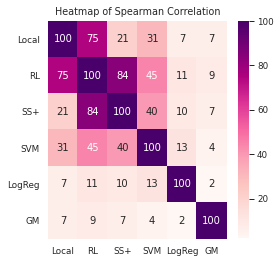

In [53]:
def plot_heatmap(df, ax=None, out_file=None, dataset="STRING-400", annot=False):
    # now make a heatmap of all the datasets
    if ax is None:
#         f, ax = plt.subplots(figsize=(6,6))
        f, ax = plt.subplots(figsize=(4,4))
#     cbar = True if k == k_to_test[-1] else False
    if annot:
        ax = sns.heatmap(data=(df*100).astype(int), cmap="RdPu", annot=True, fmt='d', ax=ax)
    else:
        ax = sns.heatmap(data=df, cmap="RdPu", ax=ax)
#     ax.set_title("STRING - Spearman Correlation")
    ax.set_title("Heatmap of Spearman Correlation")
    plt.yticks(rotation=0)
    if out_file is not None:
        alg_str = "%dalgs" % (len(order))
        if annot:
            out_file = "outputs/viz/networks/overlap/%s-%s-spearman-annot.pdf" % (dataset, alg_str)
        else:
            out_file = "outputs/viz/networks/overlap/%s-%s-spearman.pdf" % (dataset, alg_str)
        print(out_file)
        os.makedirs(os.path.dirname(out_file), exist_ok=True)
        plt.savefig(out_file, bbox_inches='tight')
        plt.savefig(out_file.replace('.pdf','.svg'), bbox_inches='tight')
        # also write the values to a file
        df.to_csv(out_file.replace('.pdf','.csv'))
    return ax
df = pred_score_spearman(df_all)
ax = plot_heatmap(df, annot=True)

['Local' 'RL' 'SS+' 'SVM' 'LogReg' 'GM']
outputs/viz/networks/overlap/STRING-400-6algs-spearman-annot.pdf


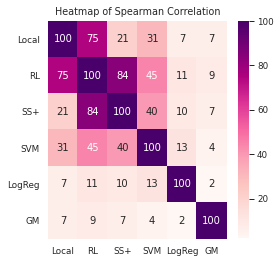

In [54]:
df = pred_score_spearman(df_all)
ax = plot_heatmap(df, out_file=True, annot=True)
# ax = plot_heatmap(df)
